In [1]:
# Need 70Gb memory to run this as peaks at just over 60gb RAM

In [2]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from useful_funcs import parse_data_dfs, make_timeseries
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import sys

di_df, pi_df, ti_df, dp_df, pp_df, tp_df = parse_data_dfs()
imperfect_final_rivs, perfect_final_rivs = list(di_df), list(dp_df)

print('Collected all base dataframes')
train_rivs, validate_rivs = train_test_split(
    imperfect_final_rivs, test_size=0.33, random_state=42)

dtrain_df = di_df.loc[:, train_rivs]
ptrain_df = pi_df.loc[:, train_rivs]
ttrain_df = ti_df.loc[:, train_rivs]

print('Transforming dataframes into timeseries dataframe')
data_days = 49
future_days = 14
rivers_to_consider = 100  # up to 1816 rivers but will be slower


def slide_window_riv(riv):
    rolling_period = data_days+future_days
    imp = riv in list(di_df)
    d = di_df[riv].rolling(
        rolling_period) if imp else dp_df[riv].rolling(rolling_period)
    p = pi_df[riv].rolling(
        rolling_period) if imp else pp_df[riv].rolling(rolling_period)
    t = ti_df[riv].rolling(
        rolling_period) if imp else tp_df[riv].rolling(rolling_period)
    all_features = []

    # sliding window through depth, pressure and temp
    for idx, (rd, rp, rt) in enumerate(zip(d, p, t)):
        # rolling window initially not full
        if len(rd) != rolling_period:
            continue
        # https://stats.stackexchange.com/questions/35304/how-to-standardize-an-array-if-standard-deviation-is-zero
        rd_d = rd.values[:data_days]
        rd_m, rd_std = np.mean(rd_d), np.std(rd_d) if np.std(rd_d) != 0 else 1
        rp_d = rp.values[:data_days]
        rp_m, rp_std = np.mean(rp_d), np.std(rp_d) if np.std(rp_d) != 0 else 1
        rt_d = rt.values[:data_days]
        rt_m, rt_std = np.mean(rt_d), np.std(rt_d) if np.std(rt_d) != 0 else 1
        feature_data = np.concatenate(
            ((rd_d-rd_m)/rd_std, (rp_d-rp_m)/rp_std, (rt_d-rt_m)/rt_std))
        features = [(rd.values[-1]-rd_m)/rd_std, riv, idx] + list(feature_data)
        all_features.append(features)
    return all_features


all_rivs = list(di_df) + list(dp_df)
X_train_df, X_val_df, X_test_df = make_timeseries(
    all_rivs[:rivers_to_consider], train_rivs, validate_rivs, slide_window_riv, data_days)
X_train_df['year_sin'] = np.sin(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_train_df['year_cos'] = np.cos(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_sin'] = np.sin(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_cos'] = np.cos(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_sin'] = np.sin(X_test_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_cos'] = np.cos(X_test_df['river_day'] * (2 * np.pi / 365.2425))


2022-11-15 22:09:43.565563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 22:09:43.643208: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Collected all base dataframes
Transforming dataframes into timeseries dataframe


Reassigning river data to correct frame: 100%|██████████| 100/100 [00:03<00:00, 31.45it/s]


Training data made
Training data sorted
Validation data made
Validation data sorted
Test data made
Test data sorted


In [3]:
gc.collect()
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

tot_size = sizeof_fmt(sum([sys.getsizeof(value) for name, value in globals().items()]))
print(f'Current total size of variables is {tot_size} ... who knows what rest is!')
# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

Current total size of variables is 690.7 MiB ... who knows what rest is!


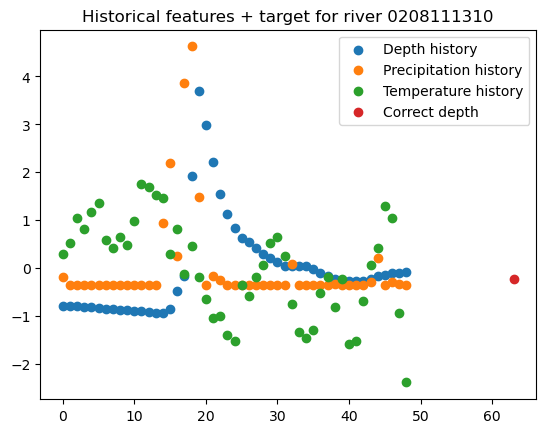

In [4]:
# What input and prediction looks like looks like
rowIdx = 42
y_point = X_train_df.iloc[rowIdx, :]['y']
all_ds = [f'd{idx}' for idx in range(data_days)]
all_ps = [f'p{idx}' for idx in range(data_days)]
all_ts = [f't{idx}' for idx in range(data_days)]
d_points = X_train_df.iloc[rowIdx, :][all_ds].to_list()
p_points = X_train_df.iloc[rowIdx, :][all_ps].to_list()
t_points = X_train_df.iloc[rowIdx, :][all_ts].to_list()
plt.scatter(range(data_days), d_points, label='Depth history')
plt.scatter(range(data_days), p_points, label='Precipitation history')
plt.scatter(range(data_days), t_points, label='Temperature history')
plt.scatter(data_days + future_days, y_point, label='Correct depth')
plt.legend()
riv_name = X_train_df.iloc[rowIdx, :]['river']
plt.title(f'Historical features + target for river {riv_name}')
plt.show()


In [5]:
# Baseline model
model = Sequential([
    Dense(1, input_shape=np.array(X_val_df.columns[3:]).shape)
])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(x=X_train_df.iloc[:, 3:], y=X_train_df.iloc[:, [0]], epochs=1000,
                    batch_size=10000,
                    validation_split=0.2)


2022-11-15 22:10:45.407418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
21/21 [==============================] - 1s 14ms/step - loss: 68.8530 - mean_absolute_error: 2.1016 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 2/1000
21/21 [==============================] - 0s 4ms/step - loss: 68.1386 - mean_absolute_error: 1.9546 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 3/1000
21/21 [==============================] - 0s 4ms/step - loss: 67.7097 - mean_absolute_error: 1.8626 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 4/1000
21/21 [==============================] - 0s 4ms/step - loss: 67.4278 - mean_absolute_error: 1.8025 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 5/1000
21/21 [==============================] - 0s 4ms/step - loss: 67.2308 - mean_absolute_error: 1.7651 - val_loss: 7443387703438581809024467992576.0000 - val_

21/21 [==============================] - 0s 3ms/step - loss: 66.4610 - mean_absolute_error: 1.7854 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 41/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4597 - mean_absolute_error: 1.7896 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 42/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4571 - mean_absolute_error: 1.7906 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 43/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4557 - mean_absolute_error: 1.7915 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 44/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4540 - mean_absolute_error: 1.7928 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absol

21/21 [==============================] - 0s 3ms/step - loss: 66.4371 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 80/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4380 - mean_absolute_error: 1.8106 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 81/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4373 - mean_absolute_error: 1.8085 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 82/1000
21/21 [==============================] - 0s 4ms/step - loss: 66.4378 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 83/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4371 - mean_absolute_error: 1.8085 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absol

21/21 [==============================] - 0s 3ms/step - loss: 66.4365 - mean_absolute_error: 1.8088 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 119/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8084 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 120/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 121/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4347 - mean_absolute_error: 1.8087 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 122/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4359 - mean_absolute_error: 1.8089 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4367 - mean_absolute_error: 1.8088 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 158/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4339 - mean_absolute_error: 1.8070 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 159/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4349 - mean_absolute_error: 1.8091 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 160/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8093 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 161/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4353 - mean_absolute_error: 1.8076 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4339 - mean_absolute_error: 1.8087 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 197/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4338 - mean_absolute_error: 1.8097 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 198/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8099 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 199/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4339 - mean_absolute_error: 1.8094 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 200/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8092 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4389 - mean_absolute_error: 1.8117 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 236/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4347 - mean_absolute_error: 1.8097 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 237/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4339 - mean_absolute_error: 1.8094 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 238/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4345 - mean_absolute_error: 1.8095 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 239/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4346 - mean_absolute_error: 1.8091 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8065 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 275/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4333 - mean_absolute_error: 1.8085 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 276/1000
21/21 [==============================] - 0s 4ms/step - loss: 66.4333 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 277/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4346 - mean_absolute_error: 1.8098 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 278/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8081 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8089 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 314/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4335 - mean_absolute_error: 1.8101 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 315/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4338 - mean_absolute_error: 1.8096 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 316/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4340 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 317/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4348 - mean_absolute_error: 1.8073 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4346 - mean_absolute_error: 1.8086 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 353/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4329 - mean_absolute_error: 1.8095 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 354/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4341 - mean_absolute_error: 1.8089 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 355/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8087 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 356/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4367 - mean_absolute_error: 1.8066 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4335 - mean_absolute_error: 1.8097 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 392/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4348 - mean_absolute_error: 1.8094 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 393/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8097 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 394/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4350 - mean_absolute_error: 1.8096 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 395/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4347 - mean_absolute_error: 1.8100 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4340 - mean_absolute_error: 1.8081 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 431/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4339 - mean_absolute_error: 1.8086 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 432/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4346 - mean_absolute_error: 1.8084 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 433/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4329 - mean_absolute_error: 1.8071 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 434/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4351 - mean_absolute_error: 1.8079 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4344 - mean_absolute_error: 1.8083 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 470/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4340 - mean_absolute_error: 1.8099 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 471/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4355 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 472/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4343 - mean_absolute_error: 1.8085 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 473/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4331 - mean_absolute_error: 1.8084 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4335 - mean_absolute_error: 1.8095 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 509/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8084 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 510/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8098 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 511/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4347 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 512/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4341 - mean_absolute_error: 1.8083 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4354 - mean_absolute_error: 1.8073 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 548/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4330 - mean_absolute_error: 1.8093 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 549/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8102 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 550/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4333 - mean_absolute_error: 1.8089 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 551/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8079 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4345 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 587/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4342 - mean_absolute_error: 1.8100 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 588/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4352 - mean_absolute_error: 1.8085 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 589/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8093 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 590/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4335 - mean_absolute_error: 1.8111 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 4ms/step - loss: 66.4337 - mean_absolute_error: 1.8088 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 626/1000
21/21 [==============================] - 0s 4ms/step - loss: 66.4357 - mean_absolute_error: 1.8082 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 627/1000
21/21 [==============================] - 0s 4ms/step - loss: 66.4331 - mean_absolute_error: 1.8075 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 628/1000
21/21 [==============================] - 0s 4ms/step - loss: 66.4328 - mean_absolute_error: 1.8090 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 629/1000
21/21 [==============================] - 0s 4ms/step - loss: 66.4345 - mean_absolute_error: 1.8101 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8077 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 665/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4340 - mean_absolute_error: 1.8076 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 666/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8087 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 667/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8086 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 668/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8099 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4353 - mean_absolute_error: 1.8092 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 704/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8111 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 705/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4352 - mean_absolute_error: 1.8086 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 706/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8067 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 707/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8089 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4344 - mean_absolute_error: 1.8100 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 743/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8073 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 744/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8104 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 745/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8096 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 746/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4338 - mean_absolute_error: 1.8066 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4329 - mean_absolute_error: 1.8110 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 782/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4345 - mean_absolute_error: 1.8091 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 783/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8113 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 784/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4338 - mean_absolute_error: 1.8098 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 785/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8099 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4340 - mean_absolute_error: 1.8077 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 821/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4347 - mean_absolute_error: 1.8108 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 822/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8074 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 823/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4335 - mean_absolute_error: 1.8083 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 824/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4330 - mean_absolute_error: 1.8093 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4347 - mean_absolute_error: 1.8071 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 860/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8082 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 861/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4327 - mean_absolute_error: 1.8089 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 862/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8099 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 863/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8074 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4329 - mean_absolute_error: 1.8076 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 899/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4341 - mean_absolute_error: 1.8093 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 900/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4348 - mean_absolute_error: 1.8077 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 901/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4339 - mean_absolute_error: 1.8097 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 902/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4341 - mean_absolute_error: 1.8088 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4339 - mean_absolute_error: 1.8101 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 938/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4371 - mean_absolute_error: 1.8082 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 939/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4332 - mean_absolute_error: 1.8086 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 940/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4334 - mean_absolute_error: 1.8092 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 941/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4330 - mean_absolute_error: 1.8084 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

21/21 [==============================] - 0s 3ms/step - loss: 66.4341 - mean_absolute_error: 1.8101 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 977/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4337 - mean_absolute_error: 1.8081 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 978/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4336 - mean_absolute_error: 1.8085 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 979/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4343 - mean_absolute_error: 1.8093 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 980/1000
21/21 [==============================] - 0s 3ms/step - loss: 66.4355 - mean_absolute_error: 1.8108 - val_loss: 7443387703438581809024467992576.0000 - val_mean_a

Really poor performance


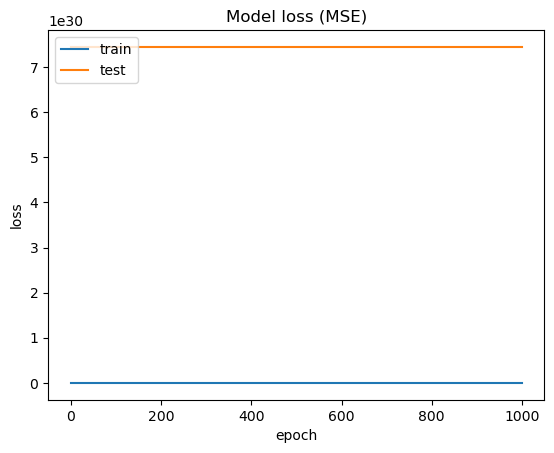

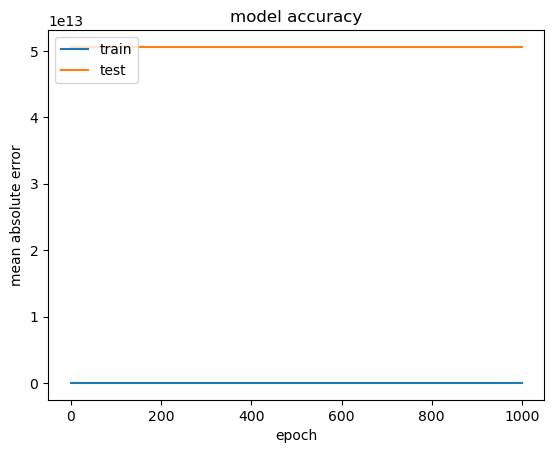

In [6]:
print('Really poor performance')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


8082/8082 [==============================] - 4s 426us/step


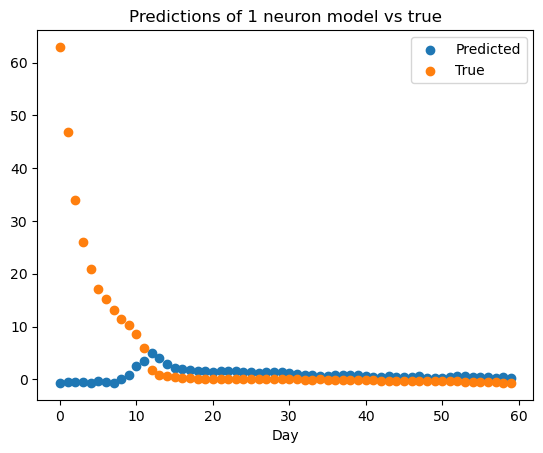

In [7]:
points = 60
df = X_train_df
predictions = model.predict(x=df.iloc[:, 3:], workers=16, use_multiprocessing=True).reshape(-1)[:points]
true_vals = df.iloc[:points, 0]
plt.scatter(range(points), predictions, label="Predicted")
plt.scatter(range(points), true_vals, label="True")
plt.legend()
plt.title('Predictions of 1 neuron model vs true')
plt.xlabel('Day')
plt.show()

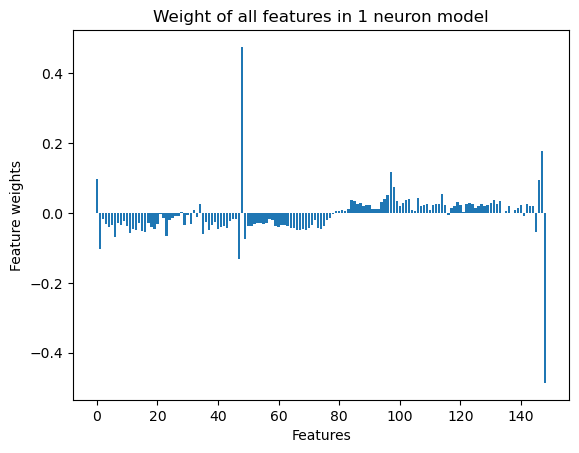

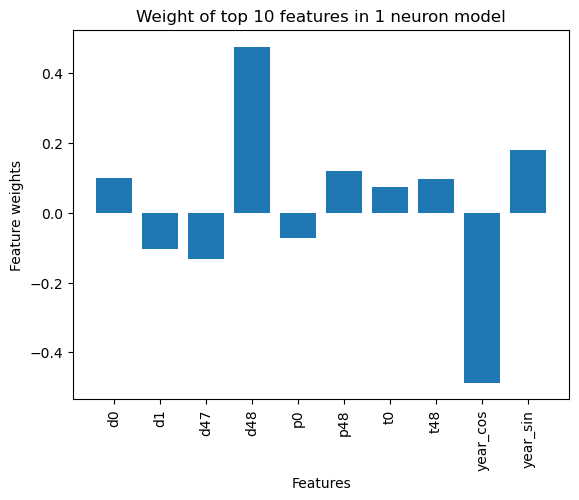

In [8]:
# based on https://www.tensorflow.org/tutorials/structured_data/time_series
cols = list(X_val_df)[3:]
plt.bar(x=range(len(cols)),
        height=model.layers[0].kernel[:, 0].numpy())
plt.title('Weight of all features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()

# top 10 features
top_num = 10
basic_coef_ord = np.argsort(np.absolute(model.layers[0].kernel[:, 0].numpy()))
new_cols = []
for idx in basic_coef_ord[-top_num:][::-1]:
    col_name = cols[idx]
    col_val = model.layers[0].kernel[:, 0].numpy()[idx]
    new_cols.append((col_name, col_val))
new_cols.sort(key=lambda x: x[0])
plt.bar(x=range(top_num),
        height=[b for a, b in new_cols])
axis = plt.gca()
axis.set_xticks(range(top_num))
_ = axis.set_xticklabels([a for a, b in new_cols], rotation=90)
plt.title(f'Weight of top {top_num} features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()


In [9]:
gc.collect()

,y
25144,62.980431
25145,46.952060
25146,34.021693
25147,26.092427
25148,20.831255
...,...
32323,-1.990159
32324,-1.945050
32325,-1.936729
32326,-1.934714


In [10]:
complex_model_2 = Sequential([
    # dense layer 1
#     tf.keras.layers.Conv1D(32, 4, activation='relu',input_shape=np.array(X_val_df.columns[3:]).shape),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(1)
])
complex_model_2.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

complex_history_2 = complex_model_2.fit(x=X_train_df.iloc[:, 3:], y=X_train_df.iloc[:, [0]], epochs=1000,
                    batch_size=20000,
                    validation_split=0.2, verbose=1)

Epoch 1/1000
11/11 [==============================] - 1s 23ms/step - loss: 67.8565 - mean_absolute_error: 1.8366 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 2/1000
11/11 [==============================] - 0s 10ms/step - loss: 66.9611 - mean_absolute_error: 1.9787 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 3/1000
11/11 [==============================] - 0s 10ms/step - loss: 66.7391 - mean_absolute_error: 1.8368 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 4/1000
11/11 [==============================] - 0s 10ms/step - loss: 66.6213 - mean_absolute_error: 1.8034 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 5/1000
11/11 [==============================] - 0s 10ms/step - loss: 66.5284 - mean_absolute_error: 1.8350 - val_loss: 7443387703438581809024467992576.0000 - 

11/11 [==============================] - 0s 10ms/step - loss: 62.0297 - mean_absolute_error: 1.9034 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 41/1000
11/11 [==============================] - 0s 11ms/step - loss: 61.6983 - mean_absolute_error: 1.9020 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 42/1000
11/11 [==============================] - 0s 11ms/step - loss: 61.3510 - mean_absolute_error: 1.9128 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 43/1000
11/11 [==============================] - 0s 12ms/step - loss: 60.9624 - mean_absolute_error: 1.9050 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 44/1000
11/11 [==============================] - 0s 12ms/step - loss: 60.4369 - mean_absolute_error: 1.9065 - val_loss: 7443387703438581809024467992576.0000 - val_mean_

11/11 [==============================] - 0s 10ms/step - loss: 24.5469 - mean_absolute_error: 1.8139 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 80/1000
11/11 [==============================] - 0s 10ms/step - loss: 23.5328 - mean_absolute_error: 1.7946 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 81/1000
11/11 [==============================] - 0s 10ms/step - loss: 22.6590 - mean_absolute_error: 1.8015 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 82/1000
11/11 [==============================] - 0s 10ms/step - loss: 21.8502 - mean_absolute_error: 1.7911 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 83/1000
11/11 [==============================] - 0s 10ms/step - loss: 21.1344 - mean_absolute_error: 1.7854 - val_loss: 7443387703438581809024467992576.0000 - val_mean_

Epoch 118/1000
11/11 [==============================] - 0s 10ms/step - loss: 14.2483 - mean_absolute_error: 1.6747 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 119/1000
11/11 [==============================] - 0s 10ms/step - loss: 14.2262 - mean_absolute_error: 1.6735 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 120/1000
11/11 [==============================] - 0s 10ms/step - loss: 14.2152 - mean_absolute_error: 1.6807 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 121/1000
11/11 [==============================] - 0s 10ms/step - loss: 14.1964 - mean_absolute_error: 1.6769 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 122/1000
11/11 [==============================] - 0s 10ms/step - loss: 14.1790 - mean_absolute_error: 1.6685 - val_loss: 74433877034385818090244679925

Epoch 157/1000
11/11 [==============================] - 0s 11ms/step - loss: 13.8389 - mean_absolute_error: 1.6564 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 158/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.8281 - mean_absolute_error: 1.6607 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 159/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.8197 - mean_absolute_error: 1.6623 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 160/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.8163 - mean_absolute_error: 1.6529 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 161/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.8105 - mean_absolute_error: 1.6601 - val_loss: 74433877034385818090244679925

Epoch 196/1000
11/11 [==============================] - 0s 11ms/step - loss: 13.3451 - mean_absolute_error: 1.6508 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 197/1000
11/11 [==============================] - 0s 11ms/step - loss: 13.3382 - mean_absolute_error: 1.6509 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 198/1000
11/11 [==============================] - 0s 11ms/step - loss: 13.3297 - mean_absolute_error: 1.6468 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 199/1000
11/11 [==============================] - 0s 11ms/step - loss: 13.3266 - mean_absolute_error: 1.6489 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 200/1000
11/11 [==============================] - 0s 11ms/step - loss: 13.3205 - mean_absolute_error: 1.6498 - val_loss: 74433877034385818090244679925

Epoch 235/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.1147 - mean_absolute_error: 1.6462 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 236/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.1101 - mean_absolute_error: 1.6470 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 237/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.1023 - mean_absolute_error: 1.6461 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 238/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.0944 - mean_absolute_error: 1.6464 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 239/1000
11/11 [==============================] - 0s 10ms/step - loss: 13.0877 - mean_absolute_error: 1.6494 - val_loss: 74433877034385818090244679925

Epoch 274/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.9151 - mean_absolute_error: 1.6512 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 275/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.9062 - mean_absolute_error: 1.6461 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 276/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.8937 - mean_absolute_error: 1.6458 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 277/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.8848 - mean_absolute_error: 1.6426 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 278/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.8894 - mean_absolute_error: 1.6486 - val_loss: 74433877034385818090244679925

Epoch 313/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.6662 - mean_absolute_error: 1.6493 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 314/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.6583 - mean_absolute_error: 1.6480 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 315/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.6607 - mean_absolute_error: 1.6451 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 316/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.6524 - mean_absolute_error: 1.6437 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 317/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.6421 - mean_absolute_error: 1.6467 - val_loss: 74433877034385818090244679925

Epoch 352/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.4776 - mean_absolute_error: 1.6519 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 353/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.4660 - mean_absolute_error: 1.6550 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 354/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.4560 - mean_absolute_error: 1.6503 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 355/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.4481 - mean_absolute_error: 1.6433 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 356/1000
11/11 [==============================] - 0s 10ms/step - loss: 12.4407 - mean_absolute_error: 1.6437 - val_loss: 74433877034385818090244679925

Epoch 391/1000
11/11 [==============================] - 0s 12ms/step - loss: 12.2667 - mean_absolute_error: 1.6484 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 392/1000
11/11 [==============================] - 0s 12ms/step - loss: 12.2630 - mean_absolute_error: 1.6453 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 393/1000
11/11 [==============================] - 0s 12ms/step - loss: 12.2657 - mean_absolute_error: 1.6467 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 394/1000
11/11 [==============================] - 0s 12ms/step - loss: 12.2642 - mean_absolute_error: 1.6486 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 395/1000
11/11 [==============================] - 0s 12ms/step - loss: 12.2392 - mean_absolute_error: 1.6524 - val_loss: 74433877034385818090244679925

Epoch 430/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.9841 - mean_absolute_error: 1.6445 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 431/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.9808 - mean_absolute_error: 1.6435 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 432/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.9686 - mean_absolute_error: 1.6421 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 433/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.9786 - mean_absolute_error: 1.6395 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 434/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.9969 - mean_absolute_error: 1.6438 - val_loss: 74433877034385818090244679925

Epoch 469/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.7518 - mean_absolute_error: 1.6382 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 470/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.7381 - mean_absolute_error: 1.6357 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 471/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.7348 - mean_absolute_error: 1.6360 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 472/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.7496 - mean_absolute_error: 1.6375 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 473/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.7515 - mean_absolute_error: 1.6358 - val_loss: 74433877034385818090244679925

Epoch 508/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.6377 - mean_absolute_error: 1.6353 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 509/1000
11/11 [==============================] - 0s 11ms/step - loss: 11.6049 - mean_absolute_error: 1.6364 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 510/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.5801 - mean_absolute_error: 1.6378 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 511/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.5769 - mean_absolute_error: 1.6368 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 512/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.5950 - mean_absolute_error: 1.6416 - val_loss: 74433877034385818090244679925

Epoch 547/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.3970 - mean_absolute_error: 1.6335 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 548/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.3863 - mean_absolute_error: 1.6308 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 549/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.3901 - mean_absolute_error: 1.6326 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 550/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.3793 - mean_absolute_error: 1.6328 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 551/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.3780 - mean_absolute_error: 1.6307 - val_loss: 74433877034385818090244679925

Epoch 586/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.2725 - mean_absolute_error: 1.6309 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 587/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.2772 - mean_absolute_error: 1.6335 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 588/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.2574 - mean_absolute_error: 1.6347 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 589/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.2480 - mean_absolute_error: 1.6323 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 590/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.2427 - mean_absolute_error: 1.6328 - val_loss: 74433877034385818090244679925

Epoch 625/1000
11/11 [==============================] - 0s 11ms/step - loss: 11.1070 - mean_absolute_error: 1.6299 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 626/1000
11/11 [==============================] - 0s 11ms/step - loss: 11.1225 - mean_absolute_error: 1.6274 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 627/1000
11/11 [==============================] - 0s 11ms/step - loss: 11.1641 - mean_absolute_error: 1.6312 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 628/1000
11/11 [==============================] - 0s 11ms/step - loss: 11.2087 - mean_absolute_error: 1.6315 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 629/1000
11/11 [==============================] - 0s 11ms/step - loss: 11.2117 - mean_absolute_error: 1.6327 - val_loss: 74433877034385818090244679925

Epoch 664/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.9552 - mean_absolute_error: 1.6224 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 665/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.9505 - mean_absolute_error: 1.6200 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 666/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.9502 - mean_absolute_error: 1.6191 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 667/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.9433 - mean_absolute_error: 1.6179 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 668/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.9373 - mean_absolute_error: 1.6184 - val_loss: 74433877034385818090244679925

Epoch 703/1000
11/11 [==============================] - 0s 10ms/step - loss: 11.0066 - mean_absolute_error: 1.6288 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 704/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.9620 - mean_absolute_error: 1.6262 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 705/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.9734 - mean_absolute_error: 1.6275 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 706/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.9335 - mean_absolute_error: 1.6239 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 707/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.9416 - mean_absolute_error: 1.6236 - val_loss: 74433877034385818090244679925

Epoch 742/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7373 - mean_absolute_error: 1.6145 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 743/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7315 - mean_absolute_error: 1.6149 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 744/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7161 - mean_absolute_error: 1.6145 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 745/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7131 - mean_absolute_error: 1.6126 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 746/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7140 - mean_absolute_error: 1.6136 - val_loss: 74433877034385818090244679925

Epoch 781/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7849 - mean_absolute_error: 1.6188 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 782/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7828 - mean_absolute_error: 1.6217 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 783/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7725 - mean_absolute_error: 1.6213 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 784/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7771 - mean_absolute_error: 1.6208 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 785/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.7372 - mean_absolute_error: 1.6198 - val_loss: 74433877034385818090244679925

Epoch 820/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.5389 - mean_absolute_error: 1.6107 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 821/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.5342 - mean_absolute_error: 1.6076 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 822/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.5302 - mean_absolute_error: 1.6092 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 823/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.5239 - mean_absolute_error: 1.6094 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 824/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.5251 - mean_absolute_error: 1.6073 - val_loss: 74433877034385818090244679925

Epoch 859/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.4982 - mean_absolute_error: 1.6116 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 860/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.4824 - mean_absolute_error: 1.6117 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 861/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.4756 - mean_absolute_error: 1.6084 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 862/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.4698 - mean_absolute_error: 1.6112 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 863/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.4613 - mean_absolute_error: 1.6117 - val_loss: 74433877034385818090244679925

Epoch 898/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.3691 - mean_absolute_error: 1.6064 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 899/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.3736 - mean_absolute_error: 1.6074 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 900/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.3765 - mean_absolute_error: 1.6073 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 901/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.3645 - mean_absolute_error: 1.6086 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 902/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.3627 - mean_absolute_error: 1.6036 - val_loss: 74433877034385818090244679925

Epoch 937/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.5248 - mean_absolute_error: 1.6190 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 938/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.5246 - mean_absolute_error: 1.6170 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 939/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.5549 - mean_absolute_error: 1.6186 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 940/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.6442 - mean_absolute_error: 1.6222 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 941/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.7220 - mean_absolute_error: 1.6257 - val_loss: 74433877034385818090244679925

Epoch 976/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.2431 - mean_absolute_error: 1.6047 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 977/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.2405 - mean_absolute_error: 1.6067 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 978/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.2350 - mean_absolute_error: 1.6068 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 979/1000
11/11 [==============================] - 0s 10ms/step - loss: 10.2325 - mean_absolute_error: 1.6057 - val_loss: 7443387703438581809024467992576.0000 - val_mean_absolute_error: 50587462795264.0000
Epoch 980/1000
11/11 [==============================] - 0s 11ms/step - loss: 10.2310 - mean_absolute_error: 1.6051 - val_loss: 74433877034385818090244679925

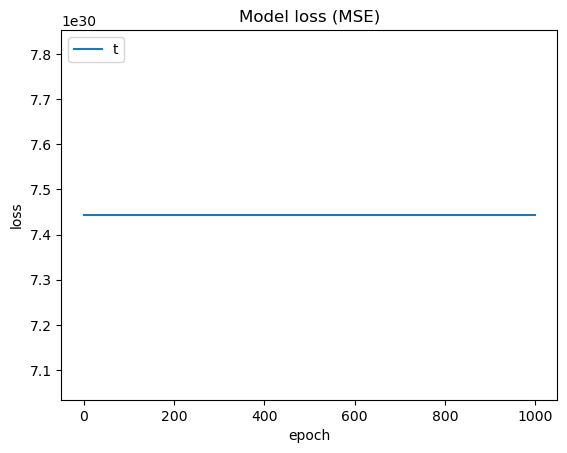

In [16]:
# plt.plot(complex_history_2.history['loss'])
plt.plot(complex_history_2.history['val_loss'])
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'][0], loc='upper left')
plt.show()

In [12]:
sum(4281664-X_train_df.count())

611502080

In [13]:
X_train_df

,y,river,river_day,d0,d1,d2,d3,d4,d5,d6,...,t41,t42,t43,t44,t45,t46,t47,t48,year_sin,year_cos
25144,62.980431,0208111310,62,-0.060141,0.286553,0.170989,0.055424,0.402118,0.633248,0.517683,...,-2.818259,-1.637797,-1.212057,-0.244465,-0.670205,-0.031595,0.297386,-1.115298,0.875550,0.483128
25145,46.952060,0208111310,63,0.317610,0.209158,0.100706,0.426062,0.642967,0.534514,0.371836,...,-1.612278,-1.190936,-0.233341,-0.654683,-0.022670,0.302913,-1.095177,-1.401607,0.883731,0.467996
25146,34.021693,0208111310,64,0.252590,0.150722,0.456325,0.660060,0.558193,0.405391,0.252590,...,-1.160297,-0.211773,-0.629123,-0.003097,0.319401,-1.065445,-1.368972,-0.951622,0.891650,0.452725
25147,26.092427,0208111310,65,0.195742,0.483483,0.675310,0.579397,0.435526,0.291656,0.147785,...,-0.177445,-0.588813,0.028239,0.346113,-1.018879,-1.318055,-0.906688,-1.205864,0.899306,0.437319
25148,20.831255,0208111310,66,0.507855,0.688507,0.598181,0.462691,0.327202,0.191713,0.056223,...,-0.565702,0.063418,0.387510,-1.004180,-1.309208,-0.889794,-1.194822,-0.260674,0.906696,0.421785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32323,-1.990159,14144800,3649,1.887597,1.856575,1.825553,1.856575,1.670442,1.236134,0.894891,...,-1.036513,-0.274503,0.106502,0.406688,0.395143,0.083411,0.256595,0.741511,-0.058885,0.998265
32324,-1.945050,14144800,3650,1.953391,1.921952,1.953391,1.764757,1.324610,0.978781,0.774427,...,-0.278965,0.098198,0.395357,0.383927,0.075339,0.246777,0.726803,1.561134,-0.041705,0.999130
32325,-1.936729,14144800,3651,2.027416,2.059385,1.867572,1.420007,1.068349,0.860551,0.652753,...,0.107228,0.408127,0.396554,0.084082,0.257678,0.743746,1.588579,1.438129,-0.024512,0.999700
32326,-1.934714,14144800,3652,2.176428,1.980659,1.523866,1.164957,0.952874,0.740791,0.610279,...,0.444863,0.432939,0.110972,0.289843,0.790679,1.661180,1.506159,0.683357,-0.007311,0.999973
